In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Road Danger Classification: Project Plan

## 1. Objective
Classify roads as **"Dangerous"** or **"Not Dangerous"** based on traffic accident data. Roads will be labeled dangerous based on criteria such as the number of fatalities, victims, and accident causes.

## 2. Data Overview
We are working with traffic accident data that contains the following columns:
- **Date**: The date of the accident.
- **Accident Spot**: The specific location of the accident.
- **Area**: The general area where the accident occurred.
- **County**: The county of the accident.
- **Road/Highway**: The road or highway where the accident occurred.
- **Brief Accident Details/Cause**: A brief description of the cause of the accident.
- **Victims**: Number of people involved in the accident.
- **Total people confirmed dead**: Number of fatalities from the accident.
- **Time of the Accidents**: Time of the accident.
- **Weather conditions**: Weather at the time of the accident (this data has sparse entries).


In [2]:
traffic_data = pd.ExcelFile('./data/TRAFFIC ACCIDENTS DATA.xlsx')
traffic_data.sheet_names

['Sheet1']

In [3]:
traffic_df = traffic_data.parse('Sheet1')

traffic_columns = list(traffic_df.columns)
traffic_df.head()

,Date,Accident Spot,Area,County,Road/ Highway,Brief Accident Details/Cause,Victims,Total people confirmed dead,Time of the Accidents,Weather conditions
0,2023-08-08,Sobea,Sobea,Nakuru,Nakuru-Eldoret Highway,Head on Collision,Passengers,4,4.30 pm,NaN
1,2023-08-07,Maai-Mahiu,Naivasha,Nakuru,Maai-Mahiu Naivasha Highway,vehicle and motorcycle collision,Passengers,1,5.50 pm,NaN
2,2023-07-25,Ntulele,Ntulele,Narok,Narok Mai Mahiu road,Head on Collision,Drivers/Occupants,4,NaN,NaN
3,2022-12-02,Suswa,Suswa,Narok,Narok Mai Mahiu road,Head on Collision,Driver and passengers,3,6.00 pm,NaN
4,2022-12-01,Mutira,Mutira,Kirinyaga,Kerugoya-Karatina Road,Run over,Pedestrian,1,NaN,NaN


In [4]:
# Data Inspection
print('Traffic Data Info: {}'.format(traffic_df.info()))
print('='*50)
print('Traffic Data Columns: {}'.format(traffic_df.columns))
print('='*50)
print('Traffic Data Shape: {}'.format(traffic_df.shape))
print('='*50)
print('Traffic Data Describe: {}'.format(traffic_df.describe(include='all')))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          80 non-null     datetime64[ns]
 1   Accident Spot                 81 non-null     object        
 2   Area                          81 non-null     object        
 3   County                        81 non-null     object        
 4   Road/ Highway                 80 non-null     object        
 5   Brief Accident Details/Cause  79 non-null     object        
 6   Victims                       63 non-null     object        
 7   Total people confirmed dead   72 non-null     object        
 8   Time of the Accidents         25 non-null     object        
 9   Weather conditions            1 non-null      object        
dtypes: datetime64[ns](1), object(9)
memory usage: 6.5+ KB
Traffic Data Info: None
Traffic Data Columns: 

In [5]:
# Standardize and clean the 'Victims' column
traffic_df['Victims'] = traffic_df['Victims'].str.lower().str.strip()

# Replace NaN values with 'unknown'
traffic_df['Victims'] = traffic_df['Victims'].fillna('unknown')

# Group similar values in the 'Victims' column
victim_mapping = {
    'passengers': 'passengers',
    'drivers/occupants': 'driver and passengers',
    'driver and passengers': 'driver and passengers',
    'pedestrian': 'pedestrian',
    'passengers and pedestrians': 'passenger and pedestrian',
    'unknown': 'unknown',
    'occupants of the small vehicle': 'passengers',
    'drivers,passengers and pedestrians': 'driver and passengers and pedestrian',
    'passengers and driver': 'driver and passengers',
    'rider': 'motorist', 
    'passengers and drivers': 'driver and passengers', 
    'passenger': 'passenger',
    'passangers and driver': 'driver and passengers', 
    'driver and other motorists': 'driver and motorist', 
    'motorist': 'motorist',
    'pedestrians': 'pedestrian'
}

traffic_df['Victims'] = traffic_df['Victims'].map(victim_mapping)

traffic_df['Victims'].unique()

array(['passengers', 'driver and passengers', 'pedestrian',
       'passenger and pedestrian', 'unknown',
       'driver and passengers and pedestrian', 'motorist', 'passenger',
       'driver and motorist'], dtype=object)

In [6]:
# Standardize and clean the 'Brief Accident Details/Cause' column
traffic_df['Brief Accident Details/Cause'] = traffic_df['Brief Accident Details/Cause'].str.lower().str.strip()
traffic_df['Brief Accident Details/Cause'].unique()

array(['head on collision', 'vehicle and motorcycle collision',
       'run over', 'car hit a stationary lorry',
       'driver lost control and swerved off the bridge',
       'vehicle rammed into a lorry', 'vehicle rolled into the bridge',
       'vehicle rolled into the river',
       'driver lost control and rammed into pillar',
       'personal vehicle rammed onto an oncoming bus',
       'matatu collided head on with an oncoming truck',
       'head on collision matatu and lorry',
       'matatu and lorry head on collision',
       'lorry failed brakes and rammed into four matatus and a saloon car',
       'matatu collided with a tractor',
       'matatu and truck head on collision',
       'bodaboda rider hit by matatu', 'bus lost control and rolled',
       'vehicle lost control nd rolled', 'saloom car rolled',
       'bus lost control and rolled into a ditch',
       'shuttle rammed into a lorry',
       'matatu hit a bump, veered off the road and landed into a ditch',
       

In [7]:
import re

def clean_accident_cause(cause):
    if pd.isna(cause):
        return 'Unknown'
    
    cause = cause.lower().strip()
    
    # Group common causes
    if re.search(r'head on|collided head on|collision|collided', cause):
        return 'Head-on Collision'
    elif re.search(r'lost control|veered off|swerved', cause):
        return 'Lost Control'
    elif re.search(r'brake failure|failed brakes', cause):
        return 'Brake Failure'
    elif re.search(r'rolled|overturned', cause):
        return 'Vehicle Rolled Over'
    elif re.search(r'rammed|hit|crashed', cause):
        return 'Collision with Vehicle/Object'
    elif re.search(r'burst|flames', cause):
        return 'Fire/Burst'
    elif re.search(r'run over|pedestrian', cause):
        return 'Pedestrian Involved'
    else:
        return 'Other Causes'

# Apply the cleaning function
traffic_df['Brief Accident Details/Cause'] = traffic_df['Brief Accident Details/Cause'].apply(clean_accident_cause)

# Check unique standardized causes
print(traffic_df['Brief Accident Details/Cause'].unique())

['Head-on Collision' 'Pedestrian Involved' 'Collision with Vehicle/Object'
 'Lost Control' 'Vehicle Rolled Over' 'Brake Failure' 'Unknown'
 'Other Causes' 'Fire/Burst']


In [8]:
# Transform Total Victims to numeric and fill missing values
traffic_df['Total people confirmed dead'] = pd.to_numeric(traffic_df['Total people confirmed dead'], errors='coerce')
traffic_df['Total people confirmed dead'] = traffic_df['Total people confirmed dead'].fillna(0).astype(int)
traffic_df['Total people confirmed dead'].unique()

array([ 4,  1,  3,  5,  6,  7,  0,  2, 12, 52, 20, 14, 10, 18,  8, 11])

In [9]:
# Lets drop `Time of the Accidents` and `Weather conditions ` columns since they have a lot of missing values
traffic_df = traffic_df.drop(['Time of the Accidents', 'Weather conditions'], axis=1)

# Check for missing values
print(traffic_df.isnull().sum())

Date                            1
Accident Spot                   0
Area                            0
County                          0
Road/ Highway                   1
Brief Accident Details/Cause    0
Victims                         0
Total people confirmed dead     0
dtype: int64


In [10]:
# Mappers 
road_mapping = {
    'Nakuru-Eldoret Highway': 'Nakuru Eldoret Highway',
    'Maai-Mahiu Naivasha Highway': 'Maai Mahiu Naivasha Highway',
    'Narok Mai Mahiu Road': 'Narok Mai Mahiu Road',
    'Kerugoya-Karatina Road': 'Kerugoya Karatina Road',
    'Kenol-Sagana Road': 'Kenol Sagana Road',
    'Meru Embu Road': 'Meru Embu Road',
    'Thika Road': 'Thika Road',
    'Nairobi - Nakuru Highway': 'Nairobi Nakuru Highway',
    'Mombasa - Nairobi Highway': 'Mombasa Nairobi Highway',
    'Nakuru Kericho Highway': 'Nakuru Kericho Highway',
    'Bomet - Sotik Highway': 'Bomet Sotik Highway',
    'Kisumu Highway': 'Kisumu Highway',
    'Kisumu - Busia Road': 'Kisumu Busia Road',
    'Nakuru - Nairobi Highway': 'Nakuru Nairobi Highway',
    'Nakuru Eldoret Highway': 'Nakuru Eldoret Highway',
    'Narok Road': 'Narok Road',
    'Isinya Kiserian Road': 'Isinya Kiserian Road',
    'Nairobi Express Way': 'Nairobi Expressway',
    'Homabay- Kendubay Road': 'Homabay Kendubay Road',
    'Eldoret Webuye Highway': 'Eldoret Webuye Highway',
    'Marsabit Isiolo Highway': 'Marsabit Isiolo Highway',
    'Migori-Kisii-Isebania Highway': 'Migori Kisii Isebania Highway',
    'Kisii Keroka Road': 'Kisii Keroka Road',
    'Rukenya Kimunye Road': 'Rukenya Kimunye Road',
    'Sagana Kenol Road': 'Sagana Kenol Road',
    'Kilifi Malindi Road': 'Kilifi Malindi Road',
    'Sagana Kagio Road': 'Sagana Kagio Road',
    'Naromoru Nanyuki Road': 'Naromoru Nanyuki Road',
    'Kenol Muranga Road': 'Kenol Muranga Road',
    'Migori Isibania Road': 'Migori Isibania Road',
    'Lodwar Kakuma Road': 'Lodwar Kakuma Road',
    'Kakamega Kisumu Road': 'Kakamega Kisumu Road',
    'Namanga Road': 'Namanga Road',
    'Kisumu Kakamega Road': 'Kisumu Kakamega Road',
    'Thika Kitui Highway': 'Thika Kitui Highway',
    'Nairobi Kakamega Road': 'Nairobi Kakamega Road',
    'Naivasha Nairobi Highway': 'Naivasha Nairobi Highway'
}

county_mapping = {
    'nakuru': 'Nakuru',
    'narok': 'Narok',
    'kirinyaga': 'Kirinyaga',
    "murang'a": "Murang'a",
    'tharaka nithi': 'Tharaka Nithi',
    'nairobi': 'Nairobi',
    'naivasha': 'Naivasha',
    'makueni': 'Makueni',
    'bomet': 'Bomet',
    'kisumu': 'Kisumu',
    'kajiado': 'Kajiado',
    'kwale': 'Kwale',
    'homabay': 'Homabay',
    'kakamega': 'Kakamega',
    'isiolo': 'Isiolo',
    'uansin gishi': 'Uasin Gishu',
    'migori': 'Migori',
    'kiambu': 'Kiambu',
    'taita taveta': 'Taita Taveta',
    'kisii': 'Kisii',
    'kilifi': 'Kilifi',
    'muranga': "Murang'a", 
    'turkana': 'Turkana',
    'kitui': 'Kitui',
    'vihiga': 'Vihiga'
}


In [11]:
# Cleaning Area, County, Accident Spot, and Road/ Highway
traffic_df['Road/ Highway'] = traffic_df['Road/ Highway'].str.strip().str.title()
traffic_df['Area'] = traffic_df['Area'].str.lower().str.strip()
traffic_df['County'] = traffic_df['County'].str.lower().str.strip()
traffic_df['Accident Spot'] = traffic_df['Accident Spot'].str.lower().str.strip()


# Raod/ Highway has one missing value and we cannot fill it with the mode since it is a unique value so we will drop the row
traffic_df = traffic_df.dropna(subset=['Road/ Highway'])


# Lets remove duplicates in County

traffic_df['County'] = traffic_df['County'].str.lower().map(county_mapping)

traffic_df['Road/ Highway'] = traffic_df['Road/ Highway'].map(road_mapping)


In [12]:
# Dealing with categorical columns; 'Victims', 'Area', 'County', 'Brief Accident Details/Cause', 'Accident Spot', 'Road/Highway'
from sklearn.preprocessing import LabelEncoder

# Victims and Brief Accident Details/Cause preprocessing
victims_encoder = LabelEncoder()
cause_encoder = LabelEncoder()

traffic_df['Victims_encoded'] = victims_encoder.fit_transform(traffic_df['Victims'])
traffic_df['Cause_encoded'] = cause_encoder.fit_transform(traffic_df['Brief Accident Details/Cause'])

# Check the encoded columns
traffic_df[['Victims', 'Victims_encoded', 'Brief Accident Details/Cause', 'Cause_encoded']].head()

# Label encoding for 'Area', 'County', 'Accident Spot', 'Road/Highway'
area_encoder = LabelEncoder()
county_encoder = LabelEncoder()
spot_encoder = LabelEncoder()
road_encoder = LabelEncoder()

traffic_df['Area_encoded'] = area_encoder.fit_transform(traffic_df['Area'])
traffic_df['County_encoded'] = county_encoder.fit_transform(traffic_df['County'])
traffic_df['Spot_encoded'] = spot_encoder.fit_transform(traffic_df['Accident Spot'])
traffic_df['Road/Highway_encoded'] = road_encoder.fit_transform(traffic_df['Road/ Highway'])

# Check the encoded columns
traffic_df[['Area', 'Area_encoded', 'County', 'County_encoded', 'Accident Spot', 'Spot_encoded', 'Road/ Highway', 'Road/Highway_encoded']].head()


,Area,Area_encoded,County,County_encoded,Accident Spot,Spot_encoded,Road/ Highway,Road/Highway_encoded
0,sobea,55,Nakuru,17,sobea,52,Nakuru Eldoret Highway,24
1,naivasha,37,Nakuru,17,maai-mahiu,24,Maai Mahiu Naivasha Highway,14
2,ntulele,44,Narok,18,ntulele,42,Narok Mai Mahiu Road,28
3,suswa,57,Narok,18,suswa,54,Narok Mai Mahiu Road,28
4,mutira,35,Kirinyaga,7,mutira,36,Kerugoya Karatina Road,7


Remaining roads with variation: Index(['Meru Embu Road', 'Mombasa Nairobi Highway', 'Nairobi Nakuru Highway',
       'Nakuru Eldoret Highway', 'Nakuru Kericho Highway',
       'Nakuru Nairobi Highway', 'Narok Mai Mahiu Road'],
      dtype='object', name='Road/ Highway')
Accidents by road with variation:               Road/ Highway    Year  Month  Accident Count
18           Meru Embu Road  2020.0    8.0               1
19           Meru Embu Road  2021.0    2.0               1
20           Meru Embu Road  2021.0    9.0               2
21           Meru Embu Road  2022.0    6.0               1
22           Meru Embu Road  2022.0    7.0               1
25  Mombasa Nairobi Highway  2022.0    9.0               1
26  Mombasa Nairobi Highway  2023.0    4.0               1
27  Mombasa Nairobi Highway  2023.0    7.0               1
28  Mombasa Nairobi Highway  2023.0    8.0               1
29  Mombasa Nairobi Highway  2023.0    9.0               3
32   Nairobi Nakuru Highway  2023.0    4.0    

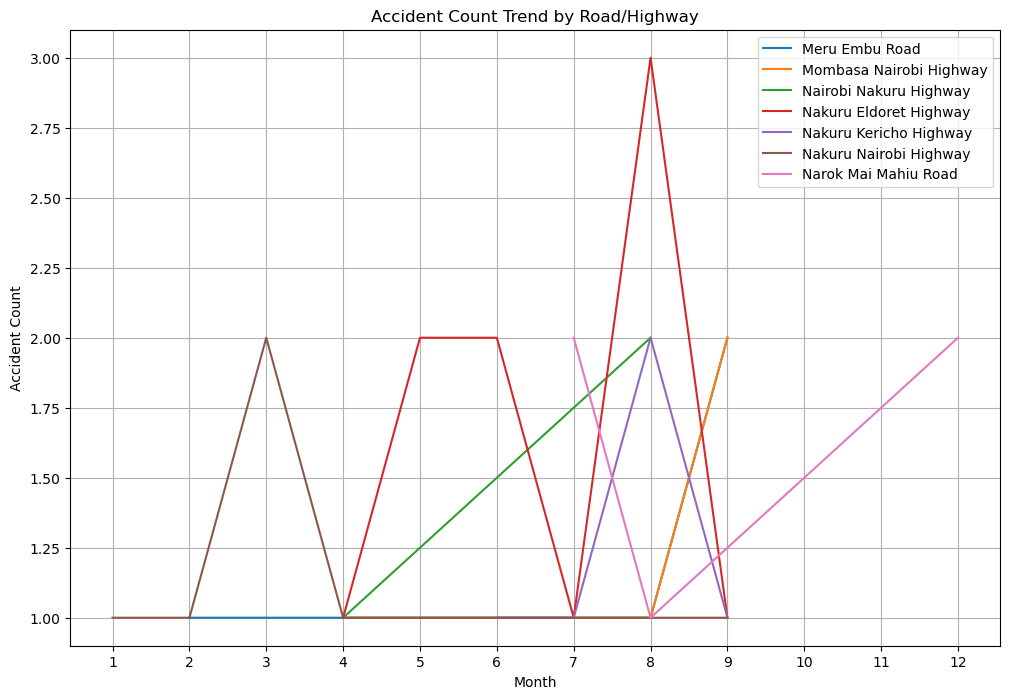

In [13]:
# Step 1: Create a copy of the DataFrame for investigation
traffic_df_copy = traffic_df.copy()

# Step 2: Convert 'Date' to datetime format
traffic_df_copy['Date'] = pd.to_datetime(traffic_df_copy['Date'], errors='coerce')

# Step 3: Extract year and month for trend analysis
traffic_df_copy['Year'] = traffic_df_copy['Date'].dt.year
traffic_df_copy['Month'] = traffic_df_copy['Date'].dt.month

# Step 4: Group by Road/Highway and Date to get accident counts over time
accidents_by_road = traffic_df_copy.groupby(['Road/ Highway', 'Year', 'Month']).size().reset_index(name='Accident Count')

# Step 5: Identify roads with no variation in accident counts (constant accident count over time)
roads_with_variation = accidents_by_road.groupby('Road/ Highway')['Accident Count'].nunique()
roads_with_variation = roads_with_variation[roads_with_variation > 1].index

# Step 6: Filter out roads with no variation
accidents_by_road_with_variation = accidents_by_road[accidents_by_road['Road/ Highway'].isin(roads_with_variation)]

# Step 7: Check the results
print(f"Remaining roads with variation: {roads_with_variation}")
print(f"Accidents by road with variation: {accidents_by_road_with_variation}")


# Step 8: Plot the trend for each road with variation
plt.figure(figsize=(12, 8))
sns.lineplot(data=accidents_by_road_with_variation, x='Month', y='Accident Count', hue='Road/ Highway')
plt.title('Accident Count Trend by Road/Highway')
plt.xlabel('Month')
plt.ylabel('Accident Count')
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

In [14]:
traffic_df['Date'].fillna(traffic_df['Date'].mode()[0], inplace=True)

# Extract year and month from the 'Date' column
traffic_df['Year'] = pd.DatetimeIndex(traffic_df['Date']).year
traffic_df['Month'] = pd.DatetimeIndex(traffic_df['Date']).month

# Drop the 'Date' column
traffic_df = traffic_df.drop('Date', axis=1)


In [15]:
# Lets Drop Categorical columns
traffic_df = traffic_df.drop(['Victims', 'Brief Accident Details/Cause', 'Area', 'County', 'Accident Spot', 'Road/ Highway'], axis=1)

In [16]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 0 to 80
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Total people confirmed dead  80 non-null     int64
 1   Victims_encoded              80 non-null     int64
 2   Cause_encoded                80 non-null     int64
 3   Area_encoded                 80 non-null     int64
 4   County_encoded               80 non-null     int64
 5   Spot_encoded                 80 non-null     int64
 6   Road/Highway_encoded         80 non-null     int64
 7   Year                         80 non-null     int32
 8   Month                        80 non-null     int32
dtypes: int32(2), int64(7)
memory usage: 5.6 KB


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import xgboost as xgb

In [ ]:
# %pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 305.0 kB/s eta 0:00:0000:0100:13
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 736.4 kB/s eta 0:00:0000:0100:06
Note: you may need to restart the kernel to use updated packages.


: 

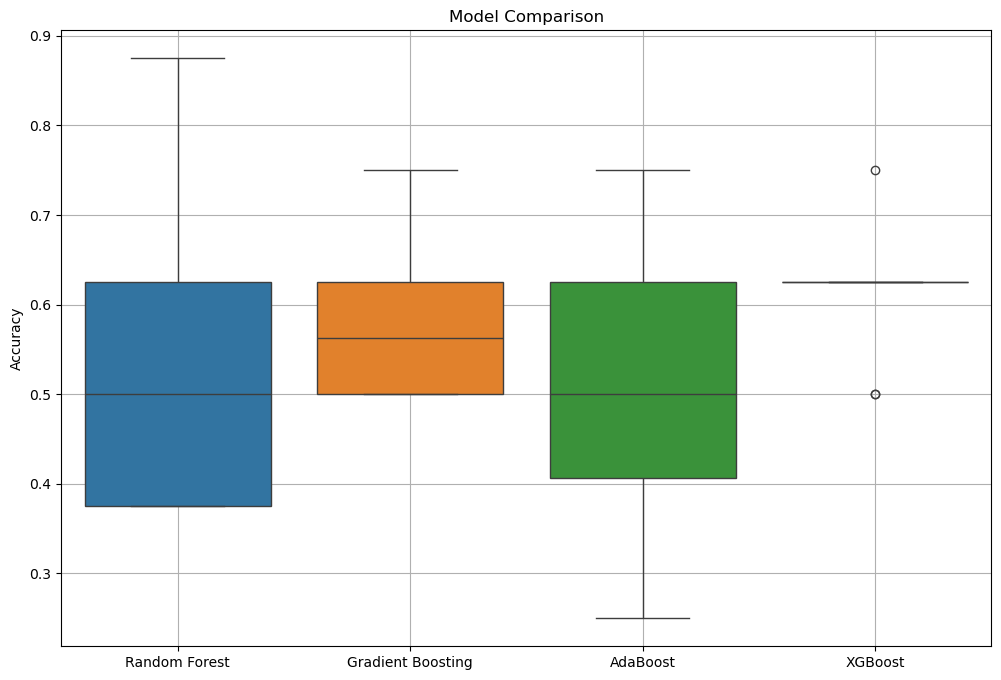

In [24]:
# Map Total people confirmed dead to binary labels (1 = Dangerous, 0 = Not Dangerous)
traffic_df['dangerous'] = traffic_df['Total people confirmed dead'].apply(lambda x: 1 if x >= 3 else 0)

# Features and target
X = traffic_df[['Victims_encoded', 'Cause_encoded', 'Area_encoded', 'County_encoded', 
                'Spot_encoded', 'Road/Highway_encoded', 'Year', 'Month']]
y = traffic_df['dangerous']

# Set up cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'AdaBoost': AdaBoostClassifier(n_estimators=100),
    'XGBoost': xgb.XGBClassifier(eval_metric='mlogloss')
}

cv_results = {}

# Train and evaluate models
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    cv_results[name] = scores

# Display results
cv_results_df = pd.DataFrame(cv_results)
# cv_results_df['Mean'] = cv_results_df.mean(axis=1)

# Lets visualize
plt.figure(figsize=(12, 8))
sns.boxplot(data=cv_results_df)
plt.title('Model Comparison')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()



#  Hyperparameter Tuning for Random Forest, Gradient Boosting, and XGBoost

In [20]:
# Hyperparameter grids for tuning

# Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1.0],
    'max_depth': [3, 7, 9],
    'max_features': ['auto', 'sqrt', 'log2']
}

# XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1.0],
    'max_depth': [3, 7, 9],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'gamma': [0, 1, 5]
}

In [22]:
# Perform grid search with cross-validation

# Random Forest
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=10, n_jobs=-1, verbose=1)
rf_grid_search.fit(X, y)

# Output best parameters and score
print(f"Best parameters for RF: {rf_grid_search.best_params_}")
print(f"Best cross-validation score for RF: {rf_grid_search.best_score_}")

Fitting 10 folds for each of 648 candidates, totalling 6480 fits
Best parameters for RF: {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score for RF: 0.575


In [23]:
# Gradient Boosting
gb_grid_search = GridSearchCV(GradientBoostingClassifier(), gb_param_grid, cv=10, n_jobs=-1, verbose=1)
gb_grid_search.fit(X, y)

# Output best parameters and score
print(f"Best parameters for GB: {gb_grid_search.best_params_}")
print(f"Best cross-validation score for GB: {gb_grid_search.best_score_}")

Fitting 10 folds for each of 324 candidates, totalling 3240 fits
Best parameters for GB: {'learning_rate': 0.1, 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 200, 'subsample': 0.7}
Best cross-validation score for GB: 0.65


In [25]:
# XGBoost
xgb_grid_search = GridSearchCV(xgb.XGBClassifier(eval_metric='mlogloss'), xgb_param_grid, cv=10, n_jobs=-1, verbose=1)
xgb_grid_search.fit(X, y)

# Output best parameters and score
print(f"Best parameters for XGB: {xgb_grid_search.best_params_}")
print(f"Best cross-validation score for XGB: {xgb_grid_search.best_score_}")

Fitting 10 folds for each of 972 candidates, totalling 9720 fits
Best parameters for XGB: {'colsample_bytree': 1.0, 'gamma': 5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
Best cross-validation score for XGB: 0.6625


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

best_rf = RandomForestClassifier(bootstrap=True, max_depth=15, max_features='sqrt',
                                 min_samples_leaf=4, min_samples_split=5, n_estimators=100)
best_rf.fit(X_train, y_train)

best_gb = GradientBoostingClassifier(learning_rate=0.1, max_depth=7, max_features='log2',
                                     n_estimators=200, subsample=0.7)
best_gb.fit(X_train, y_train)

best_xgb = xgb.XGBClassifier(colsample_bytree=1.0, gamma=5, learning_rate=0.01,
                         max_depth=3, n_estimators=200, subsample=0.7)
best_xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [32]:
# Initialize an empty list to store results
results = []

# Random Forest
rf_preds = best_rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_preds)
rf_confusion = confusion_matrix(y_test, rf_preds)
rf_report = classification_report(y_test, rf_preds, output_dict=True)

results.append({
    'Model': 'Random Forest',
    'Accuracy': rf_accuracy,
    'Precision': rf_report['weighted avg']['precision'],
    'Recall': rf_report['weighted avg']['recall'],
    'F1-Score': rf_report['weighted avg']['f1-score'],
    'Confusion Matrix': rf_confusion.tolist()
})

# Gradient Boosting
gb_preds = best_gb.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_preds)
gb_confusion = confusion_matrix(y_test, gb_preds)
gb_report = classification_report(y_test, gb_preds, output_dict=True)

results.append({
    'Model': 'Gradient Boosting',
    'Accuracy': gb_accuracy,
    'Precision': gb_report['weighted avg']['precision'],
    'Recall': gb_report['weighted avg']['recall'],
    'F1-Score': gb_report['weighted avg']['f1-score'],
    'Confusion Matrix': gb_confusion.tolist()
})

# XGBoost
xgb_preds = best_xgb.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_preds)
xgb_confusion = confusion_matrix(y_test, xgb_preds)
xgb_report = classification_report(y_test, xgb_preds, output_dict=True)

results.append({
    'Model': 'XGBoost',
    'Accuracy': xgb_accuracy,
    'Precision': xgb_report['weighted avg']['precision'],
    'Recall': xgb_report['weighted avg']['recall'],
    'F1-Score': xgb_report['weighted avg']['f1-score'],
    'Confusion Matrix': xgb_confusion.tolist()
})

# Convert the results into a DataFrame
performance_df = pd.DataFrame(results)

# Display the results
performance_df

,Model,Accuracy,Precision,Recall,F1-Score,Confusion Matrix
0,Random Forest,0.5000,0.500000,0.5000,0.500000,"[[3, 4], [4, 5]]"
1,Gradient Boosting,0.5625,0.556250,0.5625,0.557186,"[[3, 4], [3, 6]]"
2,XGBoost,0.6250,0.620455,0.6250,0.612500,"[[3, 4], [2, 7]]"


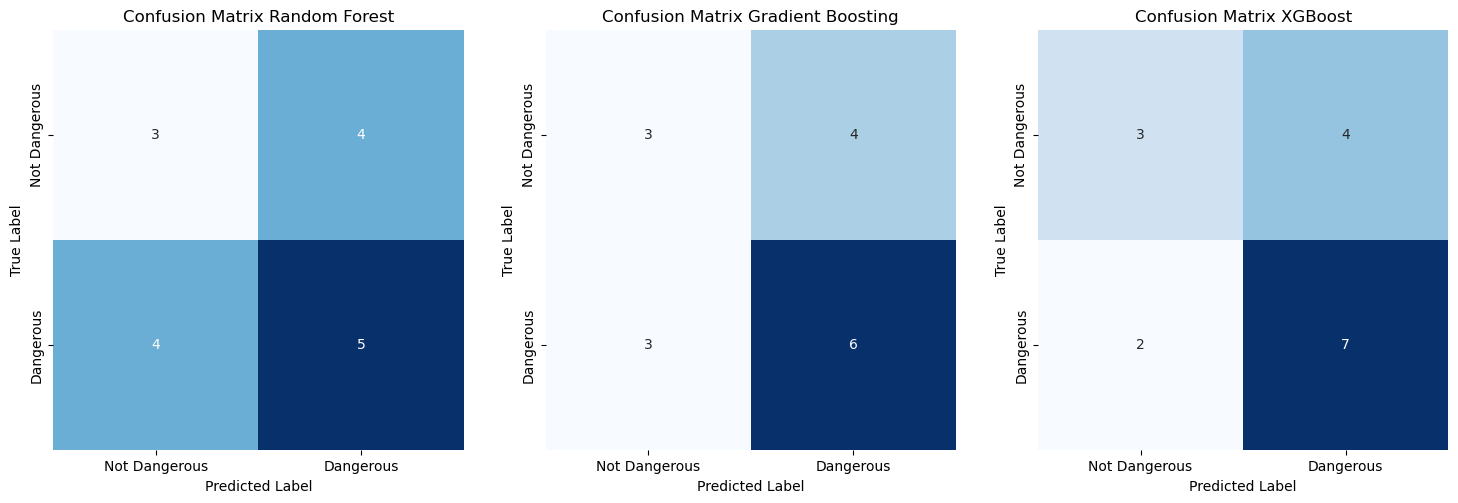

In [35]:
# Confusion Matrix for the three models
confusion_list = [rf_confusion, gb_confusion, xgb_confusion]

plt.figure(figsize=(18, 12))
for i, confusion in enumerate(confusion_list, 1):
    plt.subplot(2, 3, i)
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Not Dangerous', 'Dangerous'], yticklabels=['Not Dangerous', 'Dangerous'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix {performance_df["Model"][i-1]}')

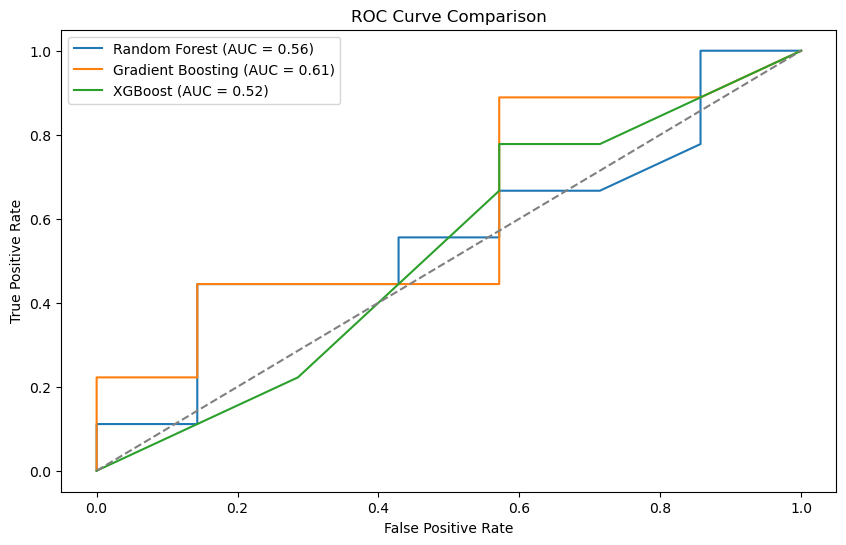

In [33]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get probabilities for ROC
rf_probs = best_rf.predict_proba(X_test)[:, 1]
gb_probs = best_gb.predict_proba(X_test)[:, 1]
xgb_probs = best_xgb.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label="Random Forest (AUC = {:.2f})".format(auc(fpr_rf, tpr_rf)))
plt.plot(fpr_gb, tpr_gb, label="Gradient Boosting (AUC = {:.2f})".format(auc(fpr_gb, tpr_gb)))
plt.plot(fpr_xgb, tpr_xgb, label="XGBoost (AUC = {:.2f})".format(auc(fpr_xgb, tpr_xgb)))
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()
